Imports

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from community import community_louvain
import random
from infomap import Infomap

Data loading and preprocessing

In [23]:
# Set folder path
data_folder = "twitter"

# Discover ego user IDs
file_list = os.listdir(data_folder)
ego_ids = set(fname.split('.')[0] for fname in file_list if fname.endswith('.edges'))

# Load all data into dictionaries
edges_dict = {}
feat_dict = {}
egofeat_dict = {}
circles_dict = {}

for ego_id in ego_ids:
    try:
        edges = pd.read_csv(f"{data_folder}/{ego_id}.edges", sep=" ", header=None, names=["From", "To"])
        edges_dict[ego_id] = edges

        feat = pd.read_csv(f"{data_folder}/{ego_id}.feat", sep=" ", header=None)
        feat.index = feat.index.astype(int)
        feat_dict[ego_id] = feat

        egofeat = pd.read_csv(f"{data_folder}/{ego_id}.egofeat", sep=" ", header=None)
        egofeat_dict[ego_id] = egofeat

        circles_path = f"{data_folder}/{ego_id}.circles"
        if os.path.exists(circles_path):
            with open(circles_path, "r") as f:
                circles = [line.strip().split("\t") for line in f]
            circles_dict[ego_id] = circles
        else:
            circles_dict[ego_id] = []
    except Exception as e:
        print(f"Error loading ego {ego_id}: {e}")

# Load feature names once

ego_id = random.choice(list(ego_ids))
sample_id = ego_id

# Or comment out the line above to use the first ID automatically
if 'ego_id' not in locals():
    sample_id = next(iter(ego_ids))  # fallback automatic
    ego_id = sample_id

print(f"Using ego network with ID: {ego_id}")

with open(f"{data_folder}/{sample_id}.featnames", "r") as f:
    featnames = [line.strip() for line in f]

Using ego network with ID: 26335321


Graph of the Ego Network for specific user

In [25]:
# Build one ego graph
ego_id = sample_id
friend_ids = feat_dict[ego_id].index.tolist()
G = nx.from_pandas_edgelist(edges_dict[ego_id], source="From", target="To", create_using=nx.DiGraph())

# Add features to friends
for i, node_id in enumerate(friend_ids):
    G.add_node(node_id)
    G.nodes[node_id]['features'] = feat_dict[ego_id].iloc[i].tolist()

# Add ego node
ego_node = int(ego_id)
G.add_node(ego_node)
G.nodes[ego_node]['features'] = egofeat_dict[ego_id].iloc[0].tolist()

# Connect ego to all friends
for friend in friend_ids:
    G.add_edge(ego_node, friend)

print(f"Graph for ego {ego_id}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

Graph for ego 26335321: 194 nodes, 727 edges.


Structural Analysis


--- Structural Analysis (Directed Graph) ---
Nodes: 197
Edges: 402
Weakly Connected Components: 7
Strongly Connected Components: 146
Average Clustering Coefficient (undirected): 0.12909786061001666
Bridge nodes (undirected view): [166330267, 14801014, 23949954, 22961983, 14520049, 37780646, 14262772, 14119238, 821042, 16896485, 19407053, 24640587, 23735198, 32886647, 24907197]


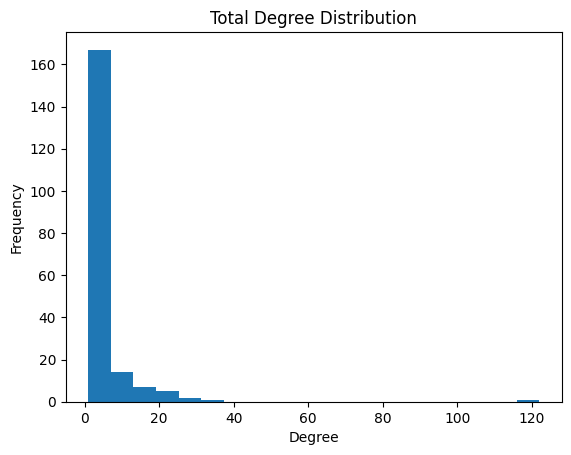

In [20]:
print("\n--- Structural Analysis (Directed Graph) ---")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Weakly Connected Components:", nx.number_weakly_connected_components(G))
print("Strongly Connected Components:", nx.number_strongly_connected_components(G))
print("Average Clustering Coefficient (undirected):", nx.average_clustering(G.to_undirected()))

# Bridge nodes based on undirected structure
bridge_nodes = list(nx.articulation_points(G.to_undirected()))
print("Bridge nodes (undirected view):", bridge_nodes)

# Degree distributions
degrees = [d for _, d in G.degree()]
plt.hist(degrees, bins=20)
plt.title("Total Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


Centrality and more Metrics

In [21]:
import networkx as nx

print("\n--- Directed Centrality Measures ---")

# In-Degree Centrality: how many users follow a node
in_deg_cent = nx.in_degree_centrality(G)

# Out-Degree Centrality: how many users a node follows
out_deg_cent = nx.out_degree_centrality(G)

# Betweenness Centrality: same as undirected, adapted for directed graphs
bet_cent = nx.betweenness_centrality(G)

# Closeness Centrality: works on directed graphs, uses incoming + outgoing paths
clo_cent = nx.closeness_centrality(G)

# PageRank: importance based on the structure of incoming links
pagerank = nx.pagerank(G, alpha=0.85)

# HITS algorithm (Hubs and Authorities)
hits_hub, hits_auth = nx.hits(G, max_iter=1000)

# Display top 5 for each metric
def display_top(metric_dict, title):
    print(f"\nTop 5 nodes by {title}:")
    for node, score in sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"Node {node}: {score:.4f}")

# Output
display_top(in_deg_cent, "In-Degree Centrality")
display_top(out_deg_cent, "Out-Degree Centrality")
display_top(bet_cent, "Betweenness Centrality")
display_top(clo_cent, "Closeness Centrality")
display_top(pagerank, "PageRank")
display_top(hits_hub, "HITS Hub Score")
display_top(hits_auth, "HITS Authority Score")



--- Directed Centrality Measures ---

Top 5 nodes by In-Degree Centrality:
Node 19685693: 0.0765
Node 47530681: 0.0714
Node 144735154: 0.0663
Node 17948572: 0.0612
Node 16665419: 0.0612

Top 5 nodes by Out-Degree Centrality:
Node 24907197: 0.6224
Node 19685693: 0.0918
Node 17948572: 0.0816
Node 36231321: 0.0765
Node 47530681: 0.0612

Top 5 nodes by Betweenness Centrality:
Node 17948572: 0.0264
Node 14119238: 0.0248
Node 14262772: 0.0227
Node 19685693: 0.0103
Node 14801014: 0.0076

Top 5 nodes by Closeness Centrality:
Node 16896485: 0.1135
Node 17948572: 0.0950
Node 14119238: 0.0941
Node 14520049: 0.0932
Node 14262772: 0.0874

Top 5 nodes by PageRank:
Node 16896485: 0.0459
Node 821042: 0.0379
Node 14268164: 0.0341
Node 14262772: 0.0312
Node 19685693: 0.0238

Top 5 nodes by HITS Hub Score:
Node 24907197: 1.0000
Node 14262772: 0.0000
Node 101787835: 0.0000
Node 21603163: 0.0000
Node 26378168: 0.0000

Top 5 nodes by HITS Authority Score:
Node 9: 0.0082
Node 13: 0.0082
Node 21: 0.0082
Node

Plot the Ego Netowork Graph

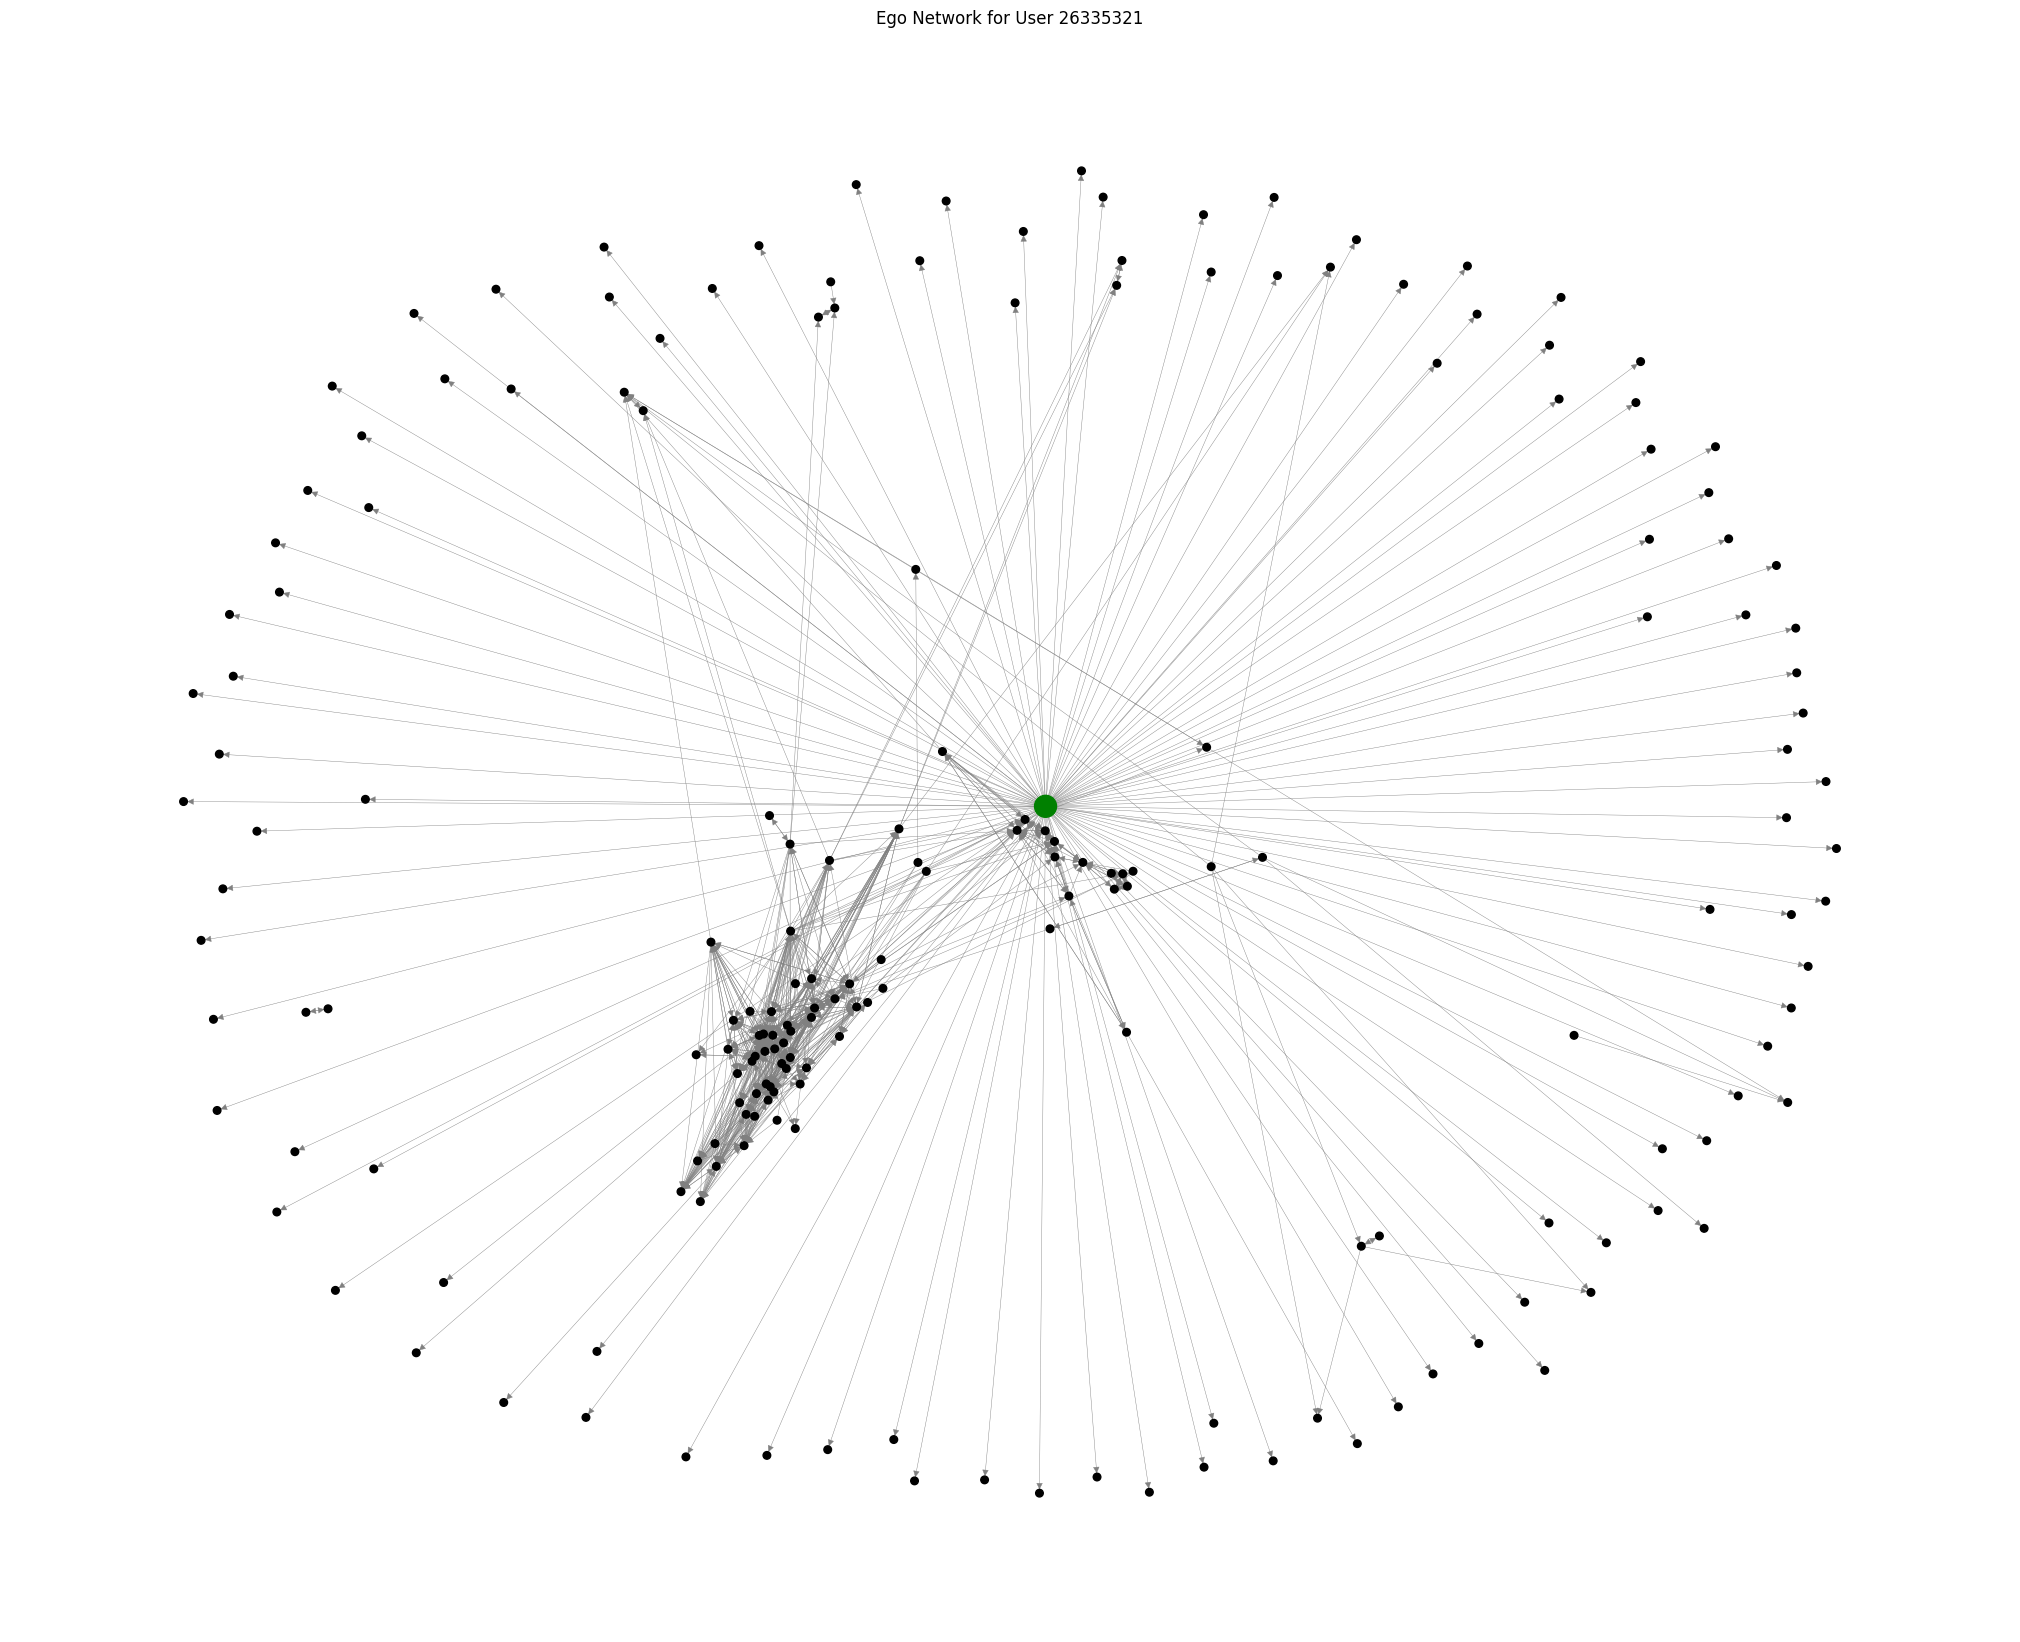

In [26]:
# Make sure ego_id is an integer (dataset keys are often strings)
ego_node = int(ego_id)

# Define node colors and sizes based on ego identity
node_colors = ['green' if node == ego_node else 'black' for node in G.nodes()]
node_sizes = [250 if node == ego_node else 30 for node in G.nodes()]

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=42)

# Plot
plt.figure(figsize=(20, 16))
nx.draw(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color='gray',
    width=0.3,
    with_labels=False
)
plt.title(f"Ego Network for User {ego_id}")
plt.show()
plt.close()

Infomap Communities

In [31]:
print("\n--- Directed Community Detection with Infomap ---")

# Run Infomap on directed graph
im = Infomap("--directed")
for u, v in G.edges():
    im.add_link(u, v)
im.run()

# Build community-to-node mapping
communities_dict = {}
for node in im.nodes:
    communities_dict.setdefault(node.module_id, set()).add(node.node_id)

print(f"Detected {len(communities_dict)} communities.")

# Analyze features for each community
print("\n--- Top Features per Community ---")

for comm_id, node_set in communities_dict.items():
    vectors = []

    for node in node_set:
        feats = G.nodes[node].get("features")
        if feats is not None:
            vectors.append(list(feats))

    if not vectors:
        print(f"Community {comm_id}: No feature data available.")
        continue

    # Standardize feature vectors
    expected_len = len(featnames)
    feature_matrix = np.zeros((len(vectors), expected_len), dtype=int)

    for i, v in enumerate(vectors):
        v = v[:expected_len] + [0] * max(0, expected_len - len(v))  # Pad or trim
        feature_matrix[i] = (np.array(v) != 0).astype(int)  # Ensure binary

    # Count feature presence
    feature_counts = feature_matrix.sum(axis=0)

    # Sort and print top 3 features
    top_k = 3
    sorted_features = sorted(enumerate(feature_counts), key=lambda x: x[1], reverse=True)

    print(f"\nCommunity {comm_id} (size: {len(node_set)})")
    for i in range(top_k):
        idx, count = sorted_features[i]
        fname = featnames[idx] if idx < len(featnames) else f"Unnamed_{idx}"
        print(f"  - {fname} (count: {int(count)})")



--- Directed Community Detection with Infomap ---
  Infomap v2.8.0 starts at 2025-06-10 21:22:12
  -> Input network: 
  -> No file output!
  -> Configuration: directed
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 
  -> Using unrecorded teleportation to links. 
  -> PageRank calculation done in 200 iterations.

  => Sum node flow: 1, sum link flow: 1
Build internal network with 194 nodes and 727 links...
  -> One-level codelength: 5.47392644

Trial 1/1 starting at 2025-06-10 21:22:12
Two-level compression: 23% 2.6% 
Partitioned to codelength 0.225305214 + 3.86251782 = 4.087823036 in 12 (11 non-trivial) modules.
Super-level compression: 0.0746064974% to codelength 4.084773255 in 6 top modules.

Recursive sub-structure compression: 19.4257611% 0.54681307% 0% . Found 4 levels with codelength 4.051656706

=> Trial 1/1 finished in 0.003545875s with codelength 4.05165671


Summary after 1 tria

Louvain Communities (Undirected)

In [32]:
excluded_keywords = {}

print("\n--- Community Detection (Directed Graph via Undirected Louvain) ---")

# Step 1: Convert directed graph to undirected for Louvain
G_undirected = G.to_undirected()

# Step 2: Run Louvain on undirected version
partition = community_louvain.best_partition(G_undirected)

# Step 3: Organize communities
communities_dict = {}
for node, comm_id in partition.items():
    communities_dict.setdefault(comm_id, set()).add(node)

# Step 4: Community stats
community_sizes = [len(nodes) for nodes in communities_dict.values()]
sorted_sizes = sorted(community_sizes, reverse=True)

print(f"Detected {len(community_sizes)} communities.")
print(f"Community sizes: {sorted_sizes}")

# Step 5: Select largest community
largest_comm_id, largest_nodes = max(communities_dict.items(), key=lambda x: len(x[1]))
largest_nodes = list(largest_nodes)

# Step 6: Gather features
vectors = []
for node in largest_nodes:
    feats = G.nodes[node].get("features")
    if feats is not None:
        vectors.append(list(feats))

if not vectors:
    print("\nNo feature data found in the largest community.")
else:
    expected_len = len(featnames)
    padded_vectors = []

    for v in vectors:
        if len(v) < expected_len:
            v += [0] * (expected_len - len(v))
        elif len(v) > expected_len:
            v = v[:expected_len]
        padded_vectors.append(v)

    feature_matrix = np.array(padded_vectors)
    binary_matrix = (feature_matrix != 0).astype(int)
    feature_counts = binary_matrix.sum(axis=0)

    # Step 7: Sort and print top features
    sorted_features = sorted(enumerate(feature_counts), key=lambda x: x[1], reverse=True)

    print(f"\n--- Analyzing Most Common Anonymized Features in Largest Community ---")
    print(f"Largest community size: {len(largest_nodes)}\n")

    print("Top 10 most common anonymized features (excluding keywords):")
    top_k = 10
    count = 0
    for idx, freq in sorted_features:
        if idx >= len(featnames):
            continue
        fname = featnames[idx]
        if any(kw in fname.lower() for kw in excluded_keywords):
            continue
        print(f"{idx}: {fname} (count: {int(freq)})")
        count += 1
        if count == top_k:
            break



--- Community Detection (Directed Graph via Undirected Louvain) ---
Detected 8 communities.
Community sizes: [101, 27, 24, 15, 10, 10, 5, 2]

--- Analyzing Most Common Anonymized Features in Largest Community ---
Largest community size: 101

Top 10 most common anonymized features (excluding keywords):
0: 0 #... (count: 100)
375: 375 @YouTube. (count: 31)
398: 398 @deathlyiam: (count: 12)
406: 406 @dutchyDC: (count: 12)
496: 496 @yeousch_remixed (count: 12)
353: 353 @TwitchTV: (count: 11)
117: 117 @DavidVonderhaar: (count: 10)
29: 29 #NASLS3 (count: 9)
153: 153 @FuzzyOtterBalls: (count: 9)
161: 161 @GoldGloveTV, (count: 9)


Apply Louvain Communities to Ego Graph

/var/folders/3j/h47tr53n7d9bgx_2tmz3q58w0000gn/T/ipykernel_76496/1435386920.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(communities))


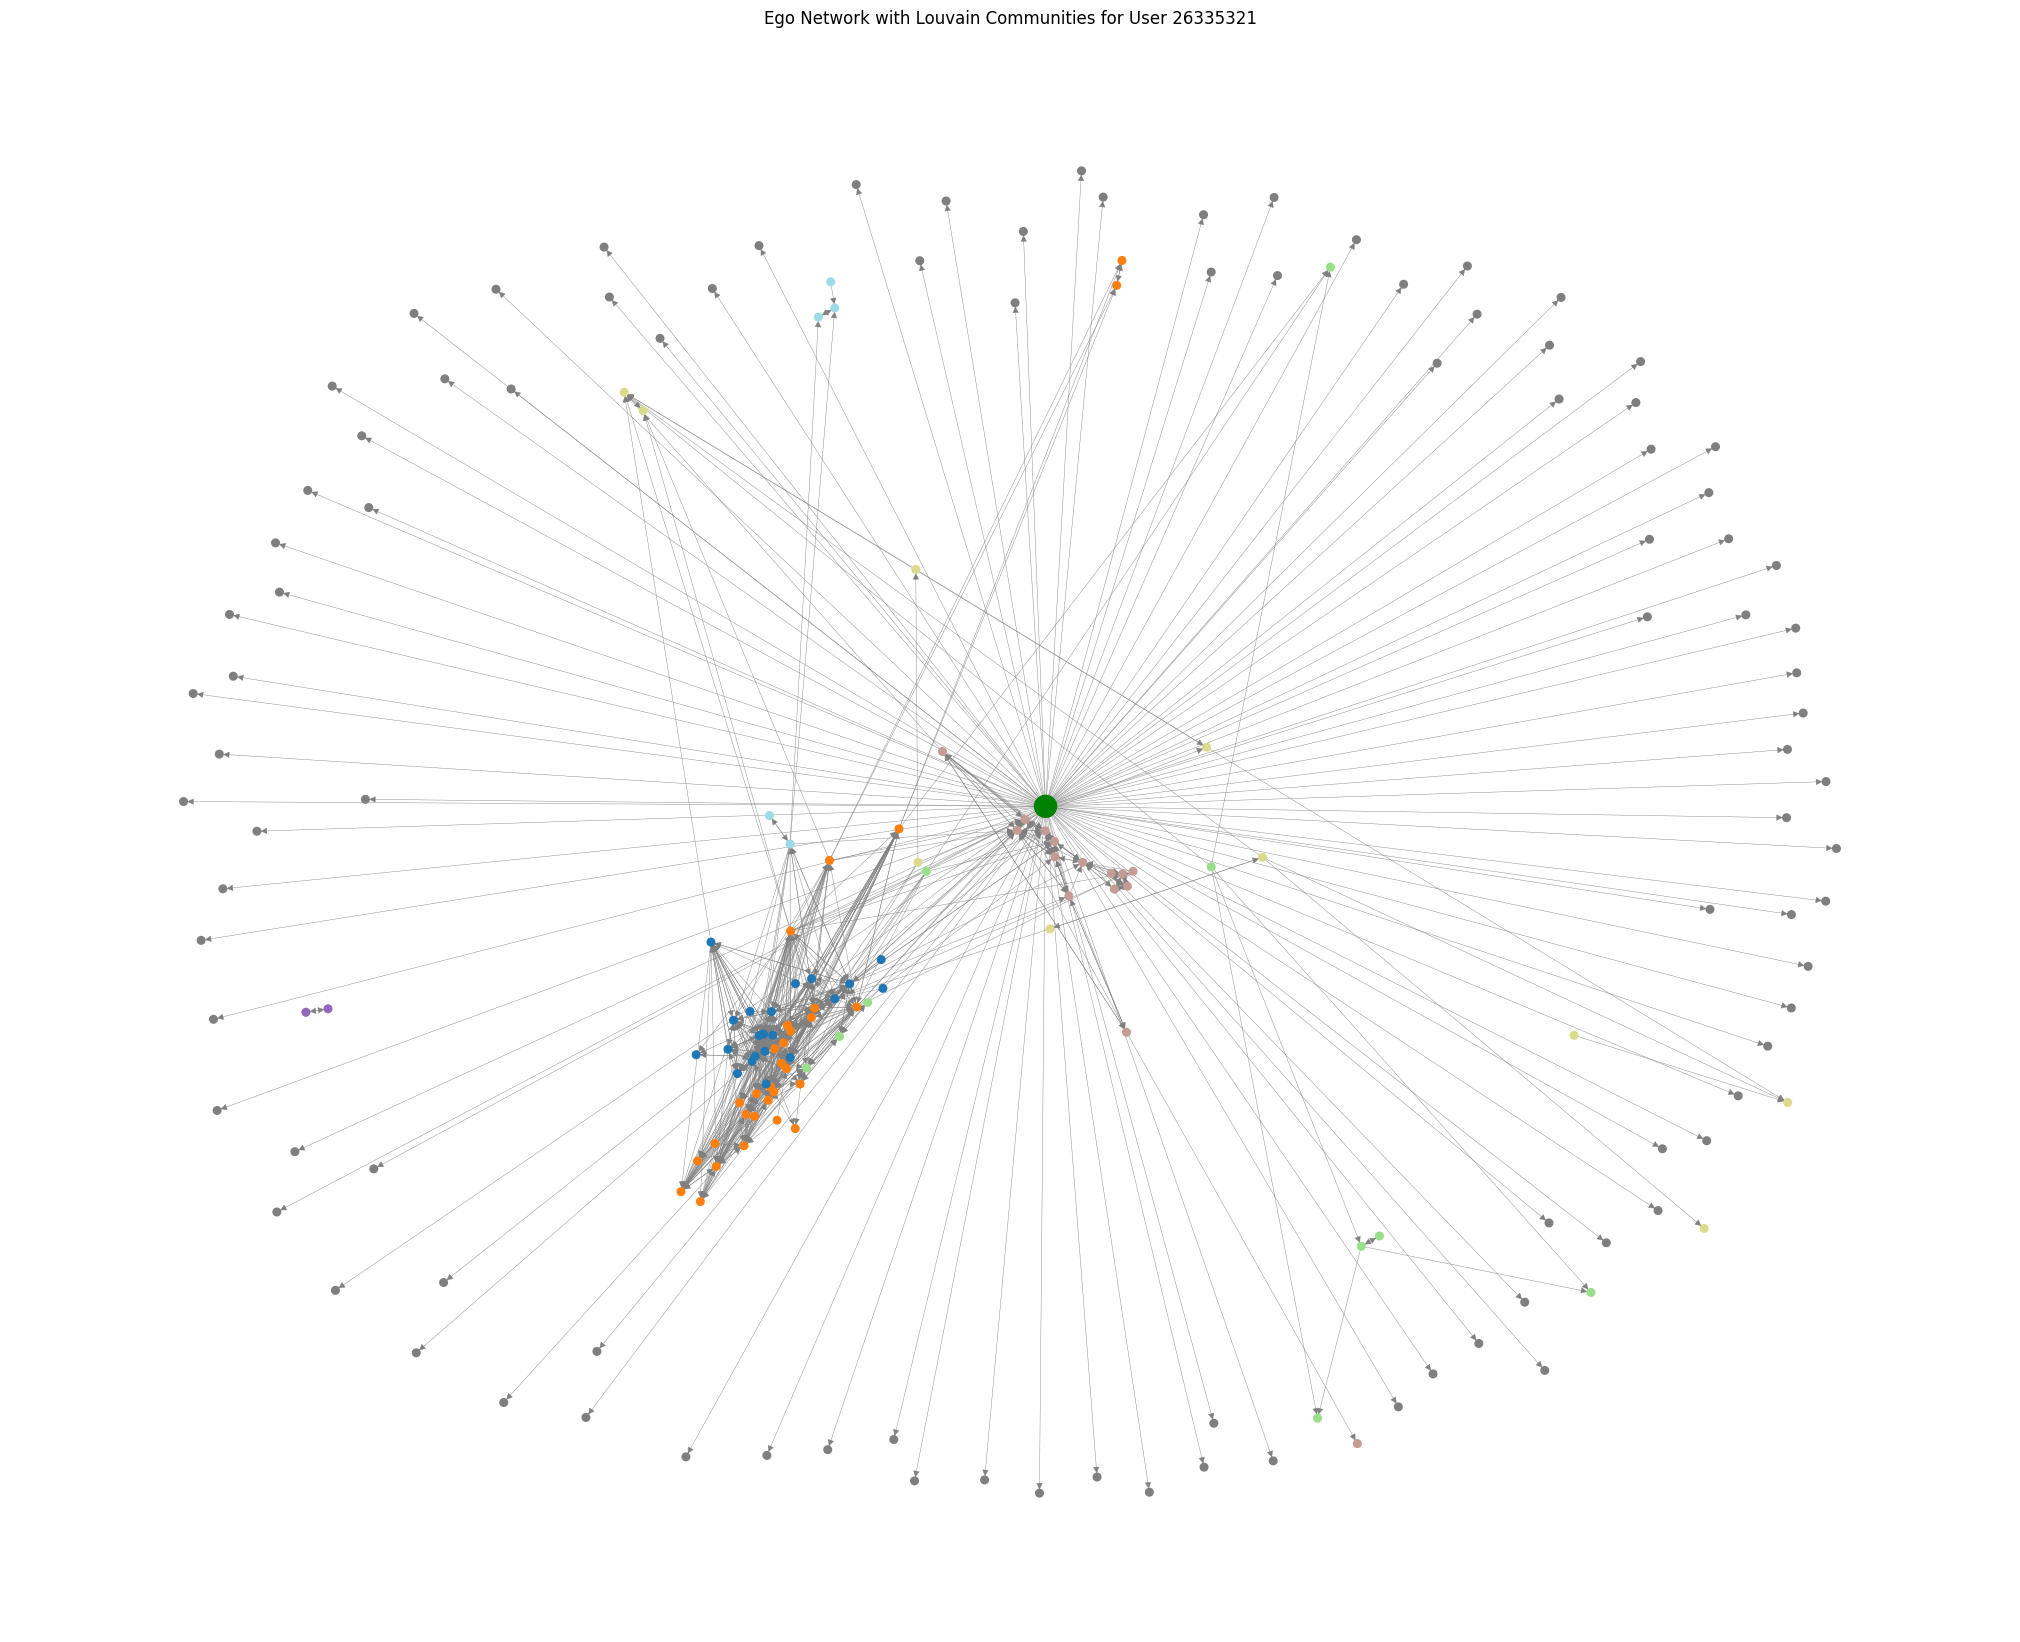

Community-colored ego network saved as ego_network_community_colored.png


In [35]:
def draw_ego_louvain(G_directed, ego_node_id, path="ego_network_community_colored.png"):
    # Step 1: Convert to undirected for Louvain
    G_undirected = G_directed.to_undirected()

    # Step 2: Louvain community detection
    partition = community_louvain.best_partition(G_undirected)

    # Step 3: Use consistent spring layout
    pos = nx.spring_layout(G_directed, seed=42)

    # Step 4: Get all community IDs and colormap
    communities = set(partition.values())
    cmap = cm.get_cmap('tab20', len(communities))

    # Step 5: Define node sizes and colors
    node_sizes = [250 if node == ego_node_id else 30 for node in G_directed.nodes()]
    node_colors = [
        'green' if node == ego_node_id else cmap(partition.get(node, 0))
        for node in G_directed.nodes()
    ]

    # Step 6: Draw network
    plt.figure(figsize=(20, 16))
    nx.draw(
        G_directed, pos,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color='gray',
        width=0.3,
        with_labels=False
    )
    plt.title(f"Ego Network with Louvain Communities for User {ego_node_id}")
    plt.show()
    plt.close()

    print(f"Community-colored ego network saved as {path}")

# Ensure the ego ID is an integer
ego_node = int(ego_id)

# Call the function with your directed graph
draw_ego_louvain(G, ego_node)


Build a Unified Graph for all Egos

In [36]:
import os
import pandas as pd
import networkx as nx

# Initialize directed graph
G = nx.DiGraph()

data_folder = "twitter"  # Replace with your path if needed

# Step 1: Read all .edges files and build unified directed graph
for file in os.listdir(data_folder):
    if file.endswith(".edges"):
        ego_id = file.split(".")[0]
        path = os.path.join(data_folder, file)
        edges_df = pd.read_csv(path, sep=' ', header=None, names=['src', 'dst'])

        # Add directed edges: src → dst (per SNAP Twitter doc: "a follows b")
        for _, row in edges_df.iterrows():
            src = str(row['src'])
            dst = str(row['dst'])
            G.add_edge(src, dst)

        # Add ego → neighbor edges (ego is followed by these users, so you may skip or invert)
        for user in pd.concat([edges_df['src'], edges_df['dst']]).unique():
            G.add_edge(ego_id, str(user))  # ego → user
        G.add_node(ego_id)  # Ensure ego node is present

print(f"Unified directed graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Step 2: Add features from .feat files
for file in os.listdir(data_folder):
    if file.endswith(".feat"):
        path = os.path.join(data_folder, file)
        features_df = pd.read_csv(path, sep=' ', header=None)
        for _, row in features_df.iterrows():
            node_id = str(row[0])
            features = row.values[1:].tolist()
            if node_id not in G:
                G.add_node(node_id)
            G.nodes[node_id]["features"] = features

# Step 3: Add ego-node features from .egofeat files
for file in os.listdir(data_folder):
    if file.endswith(".egofeat"):
        ego_id = file.split(".")[0]
        path = os.path.join(data_folder, file)
        ego_features = pd.read_csv(path, sep=' ', header=None).values[0].tolist()
        if ego_id not in G:
            G.add_node(ego_id)
        G.nodes[ego_id]["features"] = ego_features

print("All features assigned successfully.")


Unified directed graph built with 76269 nodes and 1762504 edges.
All features assigned successfully.


Find the Bridge Nodes for the unified Graph

In [38]:
import networkx as nx

# Step 1: Convert directed graph to undirected
G_undirected = G.to_undirected()

# Step 2: Remove isolated nodes (optional but often useful)
isolates = list(nx.isolates(G_undirected))
G_undirected.remove_nodes_from(isolates)

# Step 3: Find articulation points
bridge_nodes = list(nx.articulation_points(G_undirected))

# Step 4: Print them
print(f"\nNumber of articulation (bridge) nodes: {len(bridge_nodes)}")
print("Bridge nodes:")
for node in bridge_nodes:
    print(node)



Number of articulation (bridge) nodes: 202
Bridge nodes:
355823615
493138720
15331855
71091272
117800618
66841215
137527381
144211337
68179571
8210302
18690700
521489919
157488488
73025843
21731779
116388817
14404235
400867704
83285096
320527944
24907197
211547273
212718048
16987303
16437633
21094279
12570812
17403755
2841151
184594566
14849487
5506012
16193542
24636631
249829509
14203895
45857296
18687625
16421962
249831237
16652550
169780164
33080832
4258591
175529494
37899473
96843721
185512077
171536167
15481789
40777046
116808228
163491360
22970486
18226205
41945050
26335321
45690012
26234692
14555534
52330027
243267948
17767841
20758393
163374693
165786567
144723379
308220010
10798802
120459837
16809036
15947217
15129912
14129601
29034979
141341662
24815332
27853708
114115460
356897757
278311152
12831
69193714
23790454
6650612
55928029
9215692
74264908
94147192
31153819
20347014
14077024
191916463
69049114
34416153
154648125
296218728
15419775
15053535
20495756
368018677
2660470